In [81]:
from minisom import MiniSom
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random
from Square import *

data = pd.read_csv('/home/SOMPython/SOM_XYZ/SomXYZ.csv')
data = data.values
#moim zdaniem chyba nie potrzeba tutaj normalizować danych, ewentualnie po zmianach wartości x oraz y z jest zawsze -1 do 1
print(data.shape)

(10000, 3)


In [82]:
x_values = data[:,0]
y_values = data[:,1]
z_values = data[:,2]
min_x = min(x_values)
min_y = min(y_values)
max_x = max(x_values)
max_y = max(y_values)

In [83]:
def group_array(data, x_jump, y_jump):
    x_segments_count = int((max(x_values) - min(x_values)) / x_jump)
    y_segments_count = int((max(y_values) - min(y_values)) / y_jump)
    segmented_points = np.zeros((x_segments_count+1, y_segments_count+1), dtype=object)

    x = min_x
    y = min_y

    x_iterator = x_segments_count
    while(x_iterator >= 0):
       y_iterator = y_segments_count
       while(y_iterator >= 0):
          points = [point for point in data if point[0] >= x and point[0] < x + x_jump and point[1] >= y and point[1] < y+y_jump]
          x_pos = x_segments_count - x_iterator
          y_pos = y_segments_count - y_iterator
          segmented_points[x_pos,y_pos] = Square(np.array(points), x_pos, y_pos)

          y += y_jump
          y_iterator = y_iterator -1
       x += x_jump
       y = min_y
       x_iterator = x_iterator - 1
    return(np.array(segmented_points))
    
squares2d = group_array(data,10,10)
squares = squares2d.flatten()


In [84]:
squares2d[0,0].randomize_points(50)
bad_square = squares2d[0,0]
for i,j in np.ndindex(squares2d.shape):
    squares2d[i,j].svd_method()

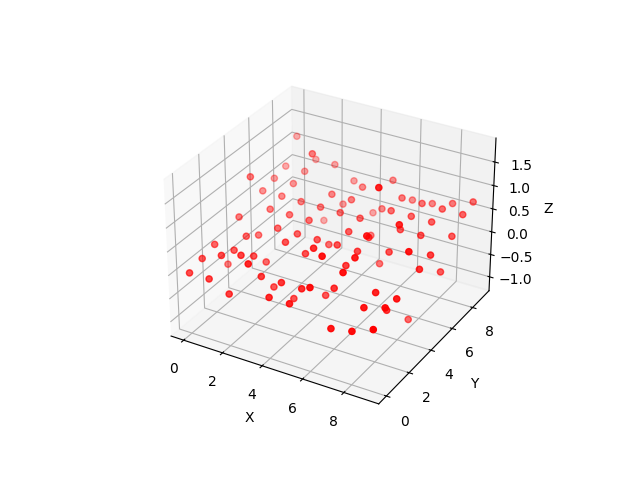

In [85]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

# Wykres punktowy 3D
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

# Ustawianie etykiet osi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Wyświetlenie wykresu
plt.show()

TO EDYTOWAĆ DLA TRENINGU

In [86]:
som_3dim = len(bad_square.normal_vector) #ilość wag w neuronie
som_grid_size = 4

normal_vectors_to_train = np.array([x.normal_vector for x in squares]) #tworzenie listy składającej się z wektorów gotowych do treningu 
labels = np.array([int(x.bad_square) for x in squares])
label_names = {0: 'Dobre', 1: 'Złe'}

In [87]:
som = MiniSom(som_grid_size, som_grid_size, som_3dim, random_seed=42)
som.train(normal_vectors_to_train, 10000)

Koniec edytowania

In [88]:
print(som.winner(bad_square.normal_vector))
print(bad_square.get_position())

(1, 3)
[0, 0]


In [89]:
#tworzenie mapy kolorów
som_colors = np.empty((som_grid_size, som_grid_size), dtype='object')
color_idx = 0
for i in range(som_grid_size):
    for j in range (som_grid_size):
        som_colors[i,j] = colors[color_idx]
        color_idx+= 1
print(som_colors[1][0])

#FF4A46


In [90]:
#kolorowanie punktów sinusoidy
winner_pos = som.winner(bad_square.normal_vector)
col = som_colors[winner_pos[0], winner_pos[1]]
print(col)
bad_square.color_my_points(col)
for square in squares:
    winner_pos = som.winner(bad_square.normal_vector)
    col = som_colors[winner_pos[0], winner_pos[1]]
    square.color_my_points(col)


#A30059


In [91]:
svd_normal_vector = bad_square.svd_method()

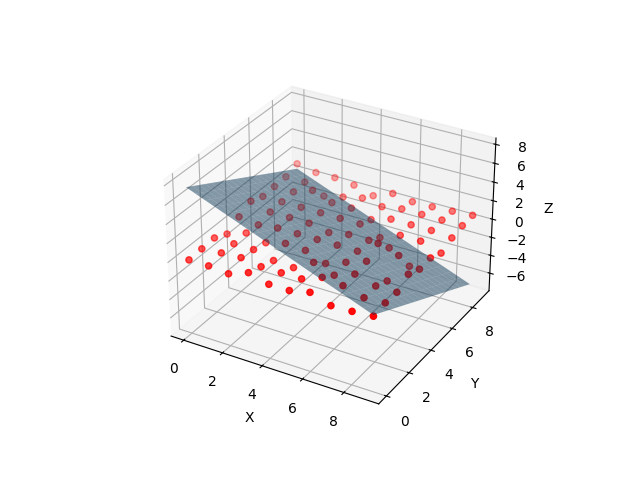

In [97]:
normal_x, normal_y, normal_Z = svd_normal_vector
centroid = bad_square.points.mean(axis=0)
# Create grid values
x = np.linspace(min(bad_square.points[:,0]), max(bad_square.points[:,0]),20) #x i y są zamienione miejscami ???
y = np.linspace(min(bad_square.points[:,1]), max(bad_square.points[:,1]),20)
xx, yy = np.meshgrid(x, y)
d = normal_x * centroid[0] + normal_y * centroid[1] + normal_Z * centroid[2]
# Calculate Z values
Z = (-normal_x * xx - normal_y * yy + d) / normal_Z

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

ax.plot_surface(xx, yy, Z, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [93]:
import csv
def print_out_squares(squares): #zmien nazwe
    formatted_numbers = []
    with open('numbers.csv', 'w', newline='') as csvfile:
        for suqare in squares:
            points_to_print = suqare.colored_points
            writer = csv.writer(csvfile)
            for point in points_to_print:
                for num in point:
                    formatted_numbers.append("{}".format(num))
                writer.writerow(formatted_numbers)
                formatted_numbers = []
print_out_squares(squares)

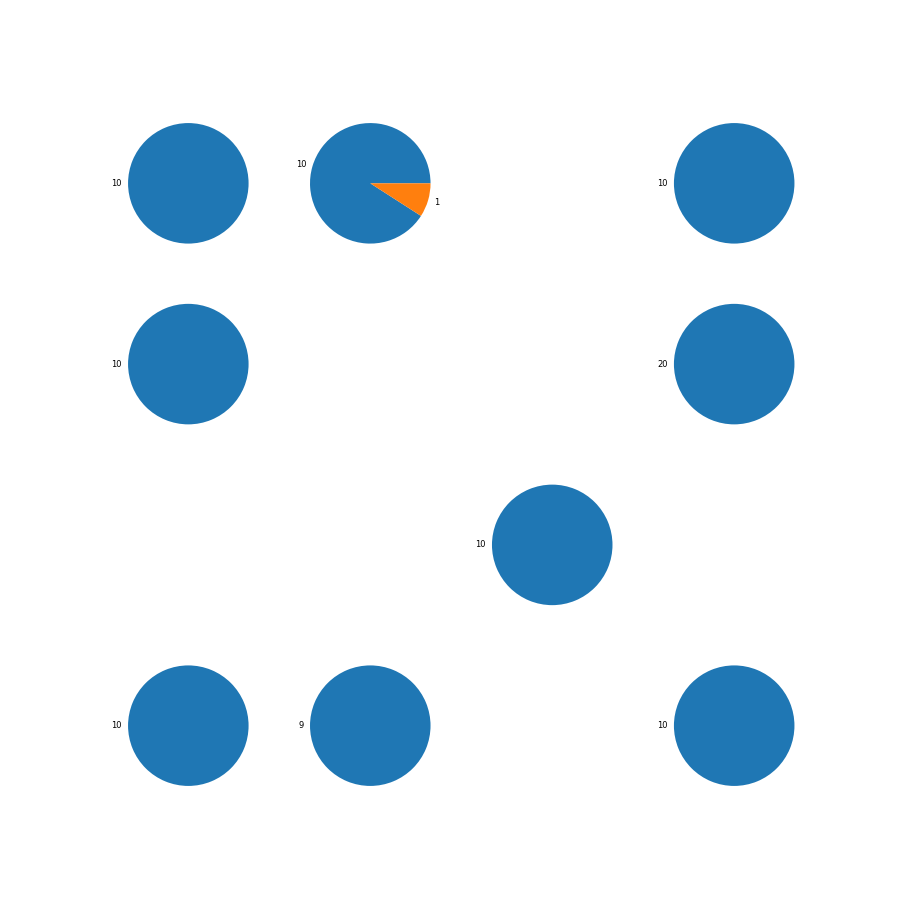

In [94]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(normal_vectors_to_train, [label_names[t] for t in labels])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(som_grid_size, som_grid_size, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[som_grid_size-1-position[1],
                         position[0]], aspect=1)
    patches, autotexts = plt.pie(label_fracs, textprops={'fontsize': 6})  # Change here

    # Add labels to show the counts
    for t, count in zip(autotexts, label_fracs):
        if count > 0:  # Only display the number if the count is greater than zero
            t.set_text(f"{count:.0f}") 

plt.legend(patches, label_names.values(), bbox_to_anchor=(5.5, 9.5), ncol=3)
plt.show()

In [95]:
#przyjrzeć się metodzie som.labels_map()
#https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
#przemyśleć czy całego generowania kwadratu nie przenieść do pliku od generowania daty
#nowa zaproponowana formuła danych: Dane: w jednej linii jeden kwadrat, Label, dla jednego kwadratu czy jest popsuty czy nie